# Análisis de la Red Meetup.com
--------------
En el siguiente estudio se realiza un esfuerzo para cuantificar el vólumen de miembros y actividades alrededor de Valencia en el ámbito tecnológico. Este estudio se basa el identificar grupos de interes comun, y el numero de miembros unicos y activos.

_Herminio Vazquez <canimus@gmail.com> en Valencia, España a 1 de Septiembre del 2016_

In [1]:
%matplotlib inline
import requests # ....................... Para llamadas HTTP al API
import json     # ....................... Para la lectura del formato de respuesta
import os       # ....................... Para utilizar variables de ambiente
import matplotlib # ..................... Para visualizar graficas en este libro
import numpy as np # .................... Para operaciones con matrices y vectores
import pandas as pd # ................... Para el manejo de datos con Data Frames
import math # ........................... Para redondeo de numeros
import matplotlib.pylab as plt # ........ Para construir las visualizaciones
from dotmap import DotMap # ............. Para convertir diccionarios en objetos

## Requisitos

**Jupyter Notebook**
Este libro de notas, esta realizado con Jupyter Notebooks, la instalación esta fuera del alcance de este proyecto, pero lo mas sencillo en entornos y sistemas operativos diferences es optar por instalar `conda` para la gestion de los paquetes necesarios, asi como la herramienta `pip` que facilita tambien la descarga e instalacion de paquetes y librerias en `python`

**Meetup API**
Los datos son directamente extraidos de su fuente natural en Meetup.com a traves de una API que ofrece la oportunidad de realizar peticiones, hasta un cierto volumen que no viole su politica de uso moderado, y los diferentes `endpoints` que su API ofrece.
Para poder ganar el acceso a esta API es necesario obtener un `API_KEY` que por efectos de seguridad ha sido pasado como una variable de ambiente a este libro de notas, para poder utilizar este mismo libro con otra llave de entrara sera necesario llamar al notebook con el siguiente comando:
```sh
# Llamada al libro de notas pasando una variable de ambiente
MEETUP_KEY=a1b2c3d4f5g6h7 jupyter notebook
```

In [162]:
# Function auxiliar para imprimir contadores a color
def print_count(count=0, text="", color=5):
    a = "{:,}".format(count)
    print("[\x1b[3" + str(color) + "m" + str(a) + "\x1b[0m] " + str(text))
    
# Impresion de top 10 de lista
def print_top(arr, qty=10, order=-1):
    for g in arr[-qty:][::order]:
        print_count(g[1], g[0])

# Extraccion de miembros recursiva por cada grupo
def extract_members(group_url, offset_limit=0):
    # Extraccion de Miembros
    payload          = {
        'key'      : os.environ['MEETUP_KEY'],        
        'page'     : 200,
        'offset'   : offset_limit
    }
    endpoint         = 'https://api.meetup.com/'
    url              = group_url
    service          = '/members'
    
    batch            = requests.get('{0}{1}{2}'.format(endpoint, group_url, service), params=payload).json()
    batch_df         = pd.DataFrame(batch)
    batch_df.joined  = pd.to_datetime(batch_df.joined, unit="ms")
    return batch_df

In [4]:
# Extraccion de Categorias
payload         = {'key' : os.environ['MEETUP_KEY']}
endpoint        = 'https://api.meetup.com/2/'
service         = 'categories'
categories      = requests.get('{0}{1}'.format(endpoint, service), params=payload).json()
categories_dict = DotMap(categories)
categories_df   = pd.DataFrame(categories['results'])

In [5]:
# Extraccion de Grupos
payload = {
    'key' : os.environ['MEETUP_KEY'],
    'category_id' : 34, # This corresponds to Tech category
    'country' : 'es',
    'city' : 'Valencia'
}
endpoint        = 'https://api.meetup.com/2/'
service          = 'groups'
tech_groups      = requests.get('{0}{1}'.format(endpoint, service), params=payload).json()
tech_groups_dict = DotMap(tech_groups)
tech_groups_df   = pd.DataFrame(tech_groups['results'])

# Conversion a objeto DateTime a partir de el numero de milisegundos que proporciona Meetup
tech_groups_df.created = pd.to_datetime(tech_groups_df.created, unit="ms")

In [6]:
print_count(tech_groups_dict.meta.count,"Grupos de tecnologia")

[47] Grupos de tecnologia


## Popularidad de los Grupos de Tecnología

El siguiente grafico nos muestra el volumen de miembros registrador por cada uno de los grupos etiquetados con un perfil tecnologico y utulizando un filtro que reduce resultados a España como país y Valencia como ciudad.

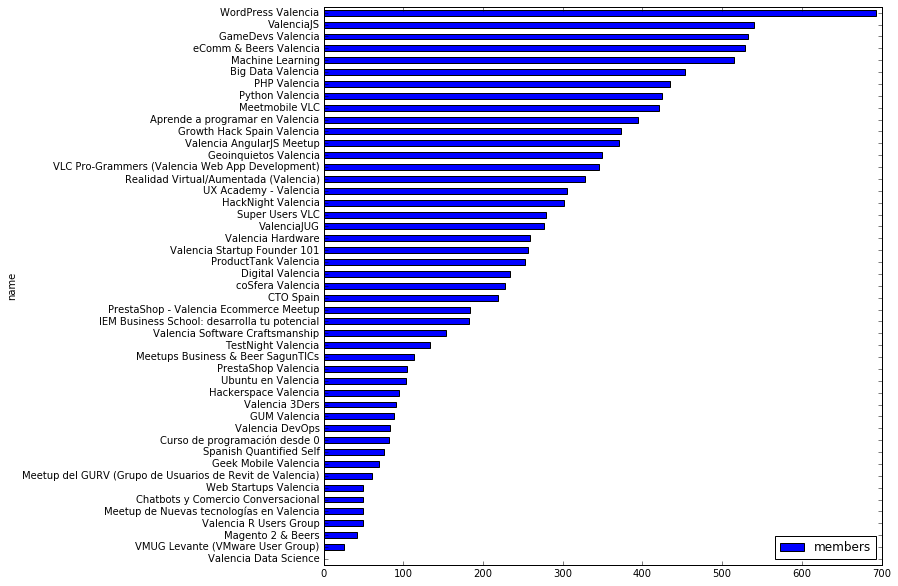

In [7]:
tech_groups_df[["name", "members"]].sort_values(by="members").plot(kind="barh", y="members", x="name", figsize=(10,10))

### Lista de los Top 10

Muestra que WordPress es popular y que JavaScript aparenta tener un gran aforo, seguidos de comercio electronico junto con las  &#x1f37a;

In [27]:
print_top(tech_groups_df[["name", "members"]].sort_values(by="members").values)

[693] WordPress Valencia
[540] ValenciaJS
[532] GameDevs Valencia
[529] eComm & Beers Valencia
[515] Machine Learning
[454] Big Data Valencia
[434] PHP Valencia
[424] Python Valencia
[421] Meetmobile VLC
[395] Aprende a programar en Valencia


### Listado de los Ultimos 5

Es bueno saber que grupos son los que menos aforo tienen, y saber cuales son las principales variantes de sus diferencias, para entender que afecta su constitucion.

In [28]:
print_top(tech_groups_df[["name", "members"]].sort_values(by="members", ascending=[False]).values, 5, -1)

[1] Valencia Data Science
[26] VMUG Levante (VMware User Group)
[42] Magento 2 & Beers
[49] Valencia R Users Group
[50] Web Startups Valencia


Profundizaremos para ver por cada unos de los grupos el numero registrado y activo de miembros, asi como su geolocalizcion en la ciudad. Para determinar que lugar concentra el mas alto nivel de teckies en Valencia.

Vamos a asumir que cada grupo tiene miembros unicos, aunque se puede predecir que determinados usuarios son miembros de mas de un grupo. Parte de este estudio sera determinar el volumen unico de usuarios potenciales de la aplicacion en la ciudad de Valencia.

In [154]:
print_count(tech_groups_df.members.values.sum(), "Suma de Miembros")

[11,202] Suma de Miembros


Extraer la informacion de todos los miembros es una rutina que lleva tiempo, dependiendo de la calidad de la conexion a internet, el archivo es aproximadamente __`21MB`__ pero una vez descargado, lo mejor es guardarlo en un archivo local, para que cada vez que se ejecute el libro de notas, no sea necesario tener que descargarlo una y otra vez. 


In [832]:
members_df = pd.DataFrame()
REQUEST_QUOTA = 200.0
for group in tech_groups_dict.results:
    # Check the current number of members
    total_members = group.members
    iteraciones = math.ceil(total_members/REQUEST_QUOTA)
    for i in range(iteraciones):
        frame = extract_members(group.urlname, i)
        members_df = members_df.append(frame, ignore_index=True)

Como los datos ahora se encuentran en dos diferentes DataFrames, lo que haremos sera vectorizar un par de funciones para aplicarlas a cada uno de los miembros, y de esa forma obtener referencias entre DataFrames que nos permitan llevar a cabo nuestro analysis, es una especia de `JOIN` manual, quizas no lo mas eficiente, pero al menos de esta forma podremos tener la informacion necesaria en un DataFrame para entender el comportamiento de los usuarios que se incorporan a los grupos.

In [833]:
time_keys = ["visited", "created", "updated"]
def group_info(x):
    if isinstance(x, dict): 
        a,b,c = [pd.to_datetime(v, unit="ms") for k, v in x.items() if k in time_keys]        
        return [x.get('group').get('id'),a,b,c]


f1 = np.vectorize(group_info)

g1 = members_df.values[:,[5,6,10,13]]
g2 = f1(members_df.group_profile.values)

In [705]:
def get_group_created(row):
    if row['group_id']:
        return tech_groups_df.query('id == '+str(row['group_id'])).created.values[0]

df2["group_created"] = df2.apply(lambda row: get_group_created(row), axis=1)

In [569]:
g3 = np.empty(g1.shape, dtype=object)

In [570]:
g3.shape

(10794, 4)

In [571]:
i = 0

for k in g2:
    j = 0
    if isinstance(k, list):
        for v in k:
            g3[i][j] = v
            j += 1
    i += 1

In [573]:
g5 = np.concatenate((g1,g3), axis=1)

In [579]:
g5.shape

(10794, 8)

In [619]:
df2 = pd.DataFrame(g5, columns=["id","joined", "name", "status", "group_id", "visited", "created", "updated"])

In [741]:
df2["join_after_days"] = (df2.created - df2.group_created.astype(object)).dt.days

## Cuando se unirá al grupo el siguiente miembro?

El histograma que se presenta a relacion de los días transcurridos, despues de la creacion del grupo, y la adición de un miembro al grupo, excluyendo al moderador o creador del grupo. 

El resultado demuestra que para 25% de los grupos los nuevos miembros llegan en una franja temporal de 30 dias naturales, no tomando en cuenta ninguna otra variable en consideracion. Para poder hacer una correlacion y predicciones, quizas tengamos que ampliar el modelo para considerar meses, dias, horas, y los topicos que se abordan en el grupo, asi como tambien, la correlacion con la creacion de eventos asociadas al grupo. 

Pero para comenzar, y solo explorar los datos, se presenta una distribucion que calcula los dias de diferencia entre el dia que se creo el grupo, y la fecha de incorporacion del segundo miembro, asumiendo que el primer miembro es el coordinador del grupo, y que el grupo solo cuenta con un coordinador.

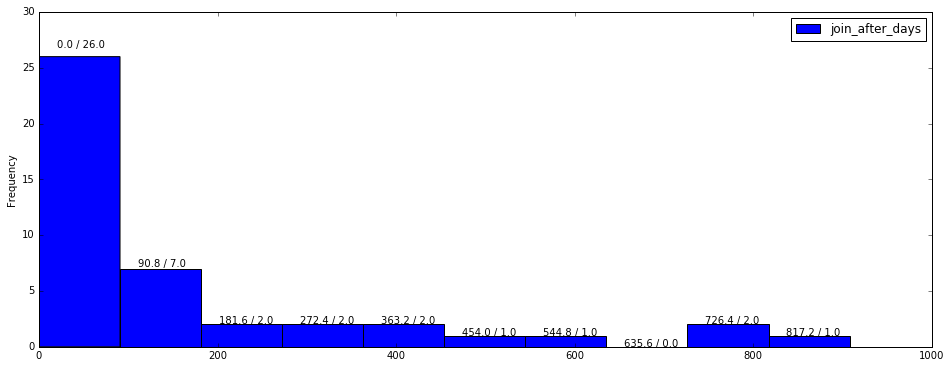

In [831]:
p1 = df2.groupby('group_id').nth(2)[["join_after_days"]].sort_values(by="join_after_days").plot(kind="hist", figsize=(16,6))
for p in p1.patches:
    p1.annotate(str(round(p.get_x(),2))+" / "+str(round(p.get_height(),0)), (p.get_x() + 20.0, p.get_height() * 1.03))

In [827]:
df2.groupby('group_id').nth(2)[["join_after_days"]].sort_values(by="join_after_days").quantile(q=0.50)

join_after_days    49.0
dtype: float64

Los datos demuestran que para el 50% de los grupos, la incorporacion de nuevos miembros sucede a los __49 dias__ naturales de la creacion del grupo. Veremos si este modelo se sostiene como verdadero, para el grupo de Data Science en Valencia. &#x1f530;

In [ ]:
# Impresion de grafico complejo para monitoreo de adicion a grupos
#pd.groupby(df2, by=[df2.group_id, df2.created.dt.year, df2.created.dt.month]).size().plot(kind="bar", title="Visits distributed by Month", color="green", figsize=(20,20))

Vamos a proceder a guardar los resultados localmente para no tener que volver a descargar todos los miembros de los meetups y tener que consumir el numero limitado de peticiones por hora que se tienen disponibles en el API

```sh
file all_members.json
```

In [ ]:
with open('all_members.json', 'w') as outfile:
    json.dump(members_df.to_json(), outfile)

# Continuación....... &#x1f51c;


## Extranjeros

No todos los usuarios que estan en los meetups en Valencia tienen su residencia en la Valencia, por ello es importante identificar quienes tienen su registro fuera de Valencia, para poder asi filtrar los individuos que en realidad participan en los meetups locales

In [ ]:
country_filter = members_df.query('country != "es"').groupby(["country"]).size().sort_values()
country_filter.plot(kind="barh", x="country", figsize=(10,10))

In [ ]:
country_values = pd.DataFrame({"count": country_filter.values, "country": country_filter.index})
country_values = country_values[["country", "count"]]
print_top(country_values.values, 10)

Ingleses, Americanos e Irlandeses son los paises que mas afiliados tienen a Meetups in Valencia, con un numero considerablemente mayor al de los demas paises de habla hispana.

## Valencianos

Ok, ya que tenemos filtrados a extranjeros cuya ciudad de residencia esta fuera de Valencia, vamos a enfocarnos en los usuarios unicos, que esten activos y ver si su actividad en meetup es reciente, obteniendo esa informacion a traves del campo `visited` que indica la ultima fecha en que entro al sitio de Meetup.com

In [ ]:
spanish    = members_df.query('country == "es"').id.unique()
valencians = members_df.query('country == "es" and city == "Valencia"').id.unique()
print_count(spanish.size, "Españoles")
print_count(valencians.size, "Valencianos")

In [ ]:
i = 1
for n in list(map(lambda x: x.organizer.name, tech_groups_dict.results)):
    print_count(i, n)
    i += 1